In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs 

### plotting 
from matplotlib import pyplot as plt
import seaborn as sns

### dask 
from dask.diagnostics import ProgressBar

In [3]:
import dask

### paths 

In [4]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### load local libraries 

In [5]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

In [6]:
sys.path.append('../../') 

In [7]:
from ICU_Water_Watch import geo, C3S, domains, plot, verification

In [78]:
domains.domains

{'Tropical_Pacific': [140, 220, -25, 25],
 'SW_Pacific': [172.5, 190, -22.5, -12],
 'Fiji': [175, 183, -21, -15],
 'NZ': [161, 181, -50, -30],
 'Pacific': [140, 240, -50, 25],
 'C3S_download': [100, 240, -50, 30],
 'Water_Watch': [120, 240, -35, 25]}

In [79]:
domain = domains.domains['Water_Watch']

### import libraries for validation

In [8]:
import climpred
from climpred import HindcastEnsemble
import xskillscore as xs

### parameters for papermill 

In [9]:
verif_dset = 'ERA'
quantile = 'quartile'
varname = 'TPRATE'
period = 'seasonal'
step = 3

In [10]:
opath_mme_probabilities = CWD.parents[1].joinpath(f"outputs/C3S_MME_{quantile}_probabilities")

In [12]:
lfiles = list(opath_mme_probabilities.glob("*"))

In [14]:
lfiles

[PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/C3S_MME_quartile_probabilities/C3S_MME_seasonal_quartile_probabilities.zarr')]

In [15]:
dset_mme = xr.open_zarr(opath_mme_probabilities.joinpath("C3S_MME_seasonal_quartile_probabilities.zarr"))

In [16]:
dset_mme

,Array,Chunk
Bytes,2.02 GiB,1.76 MiB
Shape,"(8, 288, 4, 3, 81, 121)","(8, 288, 1, 1, 10, 10)"
Count,1405 Tasks,1404 Chunks
Type,float64,numpy.ndarray


### take the leadtime in the GCM

In [18]:
dset_mme = dset_mme.sel(step=3)

In [22]:
dset_mme.time[0]

<xarray.DataArray 'time' ()>
array('1993-04-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    step     int64 3
    time     datetime64[ns] 1993-04-01

In [19]:
dset_mme['time'] = dset_mme.indexes['time'] + pd.offsets.MonthBegin(step)

In [21]:
dset_mme.time[0]

<xarray.DataArray 'time' ()>
array('1993-04-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    step     int64 3
    time     datetime64[ns] 1993-04-01

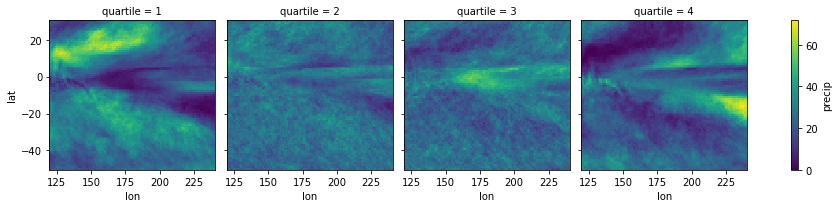

In [24]:
dset_mme.sel(GCM='MME').isel(time=0)['precip'].plot(x='lon', y='lat', col=quantile)

### most likely quartile 

In [25]:
dset_mme = dset_mme.idxmax(dim=quantile)

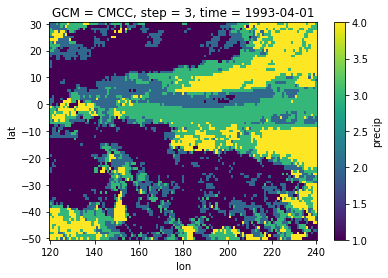

In [27]:
dset_mme['precip'][0,0,:,:].plot()

### Now reads in the verification dataset 

In [28]:
opath_verif_categories = CWD.parents[1].joinpath(f"outputs/{verif_dset}_{quantile}_categories")

In [29]:
verif_quantile_categories = xr.open_zarr(opath_verif_categories.joinpath(f"{verif_dset}_{quantile}_{period}_categories.zarr"))

### merge the datasets 

In [31]:
dset_mme, verif_quantile_categories = xr.align(dset_mme, verif_quantile_categories)

In [32]:
dset_merge = dset_mme.rename_vars({'precip':'gcm'}).merge(verif_quantile_categories.rename_vars({'precip':'verif'}))

In [33]:
dset_merge

<xarray.Dataset>
Dimensions:  (lat: 61, time: 285, GCM: 8, lon: 121)
Coordinates:
  * lat      (lat) float64 -35.0 -34.0 -33.0 -32.0 -31.0 ... 22.0 23.0 24.0 25.0
  * time     (time) datetime64[ns] 1993-04-01 1993-05-01 ... 2016-12-01
  * GCM      (GCM) <U12 'CMCC' 'DWD' 'ECMWF' 'JMA' ... 'MME' 'NCEP' 'UKMO'
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 237.0 238.0 239.0 240.0
    step     int64 3
    month    (time) int64 dask.array<chunksize=(285,), meta=np.ndarray>
Data variables:
    gcm      (GCM, time, lat, lon) float64 dask.array<chunksize=(1, 285, 5, 10), meta=np.ndarray>
    verif    (time, lat, lon) int64 dask.array<chunksize=(1, 10, 10), meta=np.ndarray>

### rechunk 

In [34]:
dset_merge = dset_merge.chunk({'time':-1, 'lat':10, 'lon':10},)

In [35]:
dset_merge.nbytes / 1e9

0.151464044

In [36]:
with ProgressBar(): 
    dset_merge = dset_merge.compute()

[########################################] | 100% Completed | 37.0s


In [37]:
dset_merge

<xarray.Dataset>
Dimensions:  (lat: 61, time: 285, GCM: 8, lon: 121)
Coordinates:
  * lat      (lat) float64 -35.0 -34.0 -33.0 -32.0 -31.0 ... 22.0 23.0 24.0 25.0
  * time     (time) datetime64[ns] 1993-04-01 1993-05-01 ... 2016-12-01
  * GCM      (GCM) <U12 'CMCC' 'DWD' 'ECMWF' 'JMA' ... 'MME' 'NCEP' 'UKMO'
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 237.0 238.0 239.0 240.0
    step     int64 3
    month    (time) int64 4 5 6 7 8 9 10 11 12 1 2 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    gcm      (GCM, time, lat, lon) float64 1.0 2.0 2.0 1.0 ... 4.0 1.0 1.0 2.0
    verif    (time, lat, lon) int64 2 3 3 2 2 2 1 2 3 3 ... 4 4 4 2 2 4 4 3 3 3

In [38]:
import xarray as xr 
from functools import partial
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix,\
precision_score

In [39]:
def tp(x, y, class_value):
    """
    x: is the GCM
    y: is the observed
    """
    intersection = ((x == class_value) * (y == class_value)).sum()
    # same as the and statement
    # multiplication ensures that this is only where both values equal the class set
    # this is the same as true positives
    return intersection 

def fp(x, y, class_value):
    """
    x: is the GCM
    y: is the observed
    """
    fps = ((x == class_value) * (~(y == class_value))).sum()
    # multiplication ensures that this is only where both values equal the class set
    # this is the same as true positives
    return fps

def fn(x, y, class_value):
    """
    x: is the GCM
    y: is the observed
    """
    fns = ((y == class_value) * (~(x == class_value))).sum()
    # multiplication ensures that this is only where both values equal the class set
    # this is the same as true positives
    return fns

def tn(x, y, class_value): 
    tns = ((~(y == class_value)) * (~(x == class_value))).sum()
    # multiplication ensures that this is only where both values equal the class set
    # this is the same as true positives
    return tns

def iou(x, y, class_value):
    intersection = ((x == class_value) * (y == class_value)).sum()
    # multiplication ensures that this is only where both values equal the class set
    union_set = (x == class_value) + (y == class_value)
    # union will combine the two (e.g. when the predicted value is 0 and observed is 1)
    union_set = np.clip(union_set, a_min =0, a_max =1).sum()
    # clipping the set, as we only want a bolean union
    return intersection /union_set

def confusion_matrix_parallel(x, y):
    x = x-1
    y = y-1
    # converting the ones to zeros
    # Note see documentation if you'd like to normalize the data
    return confusion_matrix(x, y)
       
    

In [40]:
def false_negatives(dset, class_value=1, forecast_var='gcm', verification_var='verif', input_core_dim='time'): 
    fnegatives = xr.apply_ufunc(partial(fn, class_value = class_value), dset[forecast_var], dset[verification_var],
                          input_core_dims =[[input_core_dim],[input_core_dim]],
                          output_core_dims =[[]],
                          vectorize = True,
                          dask ='parallelized',
                          output_dtypes =[float])
    return fnegatives

def false_positives(dset, class_value=1, forecast_var='gcm', verification_var='verif', input_core_dim='time'): 
    fpositives = xr.apply_ufunc(partial(fp, class_value = class_value), dset[forecast_var], dset[verification_var],
                          input_core_dims =[[input_core_dim],[input_core_dim]],
                          output_core_dims =[[]],
                          vectorize = True,
                          dask ='parallelized',
                          output_dtypes =[float])
    return fpositives

def true_positives(dset, class_value=1, forecast_var='gcm', verification_var='verif', input_core_dim='time'): 
    tpositives = xr.apply_ufunc(partial(tp, class_value = class_value), dset[forecast_var], dset[verification_var],
                          input_core_dims =[[input_core_dim],[input_core_dim]],
                          output_core_dims =[[]],
                          vectorize = True,
                          dask ='parallelized',
                          output_dtypes =[float])
    return tpositives

def true_negatives(dset, class_value=1, forecast_var='gcm', verification_var='verif', input_core_dim='time'): 
    tnegatives = xr.apply_ufunc(partial(tn, class_value = class_value), dset[forecast_var], dset[verification_var],
                          input_core_dims =[[input_core_dim],[input_core_dim]],
                          output_core_dims =[[]],
                          vectorize = True,
                          dask ='parallelized',
                          output_dtypes =[float])
    return tnegatives

In [42]:
dset = dset_merge.sel(GCM='ECMWF')

In [43]:
fnegatives = false_negatives(dset)

In [44]:
fpositives = false_positives(dset)

In [45]:
tpositives = true_positives(dset)

In [46]:
# the precision, or the ratio of true positives to false positives
precision = tpositives/(tpositives + fpositives)
# this provides an indication of the positive predictive rate
# or what is the proportion of time will it predict correctly
#see: for more info https://en.wikipedia.org/wiki/Precision_and_recall

In [47]:
# the precision, or the ratio of true positives to false positives
recall = tpositives/(tpositives + fnegatives)
# this provides an indication of the positive predictive rate
# or what is the proportion of time will it predict correctly

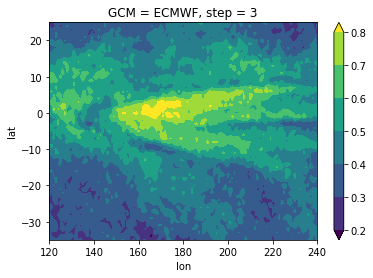

In [48]:
precision.plot.contourf(levels=np.arange(0.2, 0.9,  0.1))

In [208]:
dset = dset_merge.sel(GCM='MME')

In [209]:
class_value = 2

In [210]:
# category_name = 'lower'
category_name = 'mid-lower'

In [211]:
# category_description = "< 25th percentile"
category_description = "< 50th percentile"

In [212]:
fnegatives = false_negatives(dset, class_value=class_value)

In [213]:
fpositives = false_positives(dset, class_value=class_value)

In [214]:
tpositives = true_positives(dset, class_value=class_value)

In [215]:
# the precision, or the ratio of true positives to false positives
precision = tpositives/(tpositives + fpositives)
# this provides an indication of the positive predictive rate
# or what is the proportion of time will it predict correctly
#see: for more info https://en.wikipedia.org/wiki/Precision_and_recall

In [216]:
# the precision, or the ratio of true positives to false positives
recall = tpositives/(tpositives + fnegatives)
# this provides an indication of the positive predictive rate
# or what is the proportion of time will it predict correctly

In [217]:
cbar_kwargs = dict(shrink=0.8, orientation='vertical', drawedges=True, pad=0.01)

In [218]:
F1_Score = 2*(recall * precision) / (recall + precision)

In [219]:
import palettable

In [220]:
cmap = palettable.scientific.sequential.Oslo_20_r.mpl_colormap

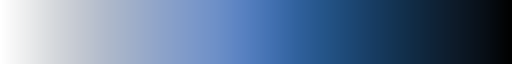

In [221]:
cmap

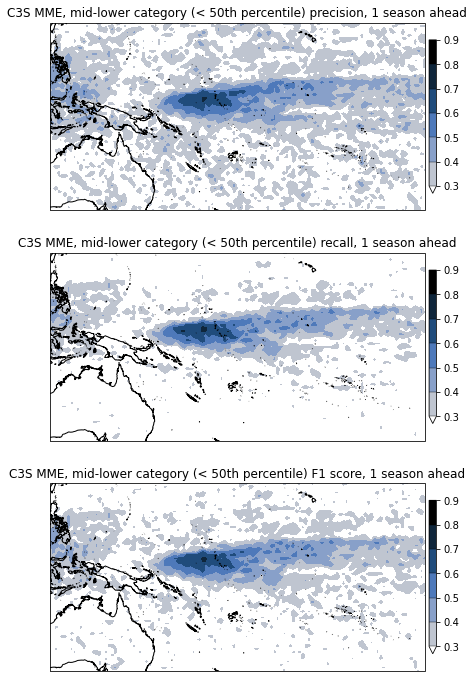

In [222]:
f, axes = plt.subplots(nrows=3, figsize=(8,12), subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))

axes = axes.flatten()

ax = axes[0]

precision.plot.contourf(ax=ax, levels=np.arange(0.3, 1,  0.1), transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, cmap=cmap)

ax.coastlines(resolution='10m')

ax.set_extent(domain, crs=ccrs.PlateCarree())

ax.set_title(f"C3S MME, {category_name} category ({category_description}) precision, 1 season ahead")

ax = axes[1]

recall.plot.contourf(ax=ax, levels=np.arange(0.3, 1,  0.1), transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, cmap=cmap)

ax.coastlines(resolution='10m')

ax.set_extent(domain, crs=ccrs.PlateCarree())

ax.set_title(f"C3S MME, {category_name} category ({category_description}) recall, 1 season ahead")

ax = axes[2]

F1_Score.plot.contourf(ax=ax, levels=np.arange(0.3, 1,  0.1), transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, cmap=cmap)

ax.coastlines(resolution='10m')

ax.set_extent(domain, crs=ccrs.PlateCarree())

ax.set_title(f"C3S MME, {category_name} category ({category_description}) F1 score, 1 season ahead")

f.savefig(f'./{category_name}_precision_recall_F1score.png', dpi=200, bbox_inches='tight', facecolor='w')